# Cars' acceptance levels- and Geo-related dataset analysis and results visulaisations

## Author: Radoslav Stefanov - @rstefanov321

# Abstract

Data is everywhere around us - from the steps we measure on our smart watch every day when we walk/run to a system log of an aircraft carying thousands of passengers daily. Within this data, we can draw some conclusions, which can improve the way we do things - I walked 1000 steps today, need to improve this to reach my weight goal. Those indicator in the luggage department is giving some false information, it needs to be checked. Therefore, collecting and understanding data is key to our progress in any sphere of life. 

In this document, two topics will be discussed. The first one is the acceptance level of cars based on their features, such as maintenance, sales, number of doors, luggage room, etc. The results reveal pretty much expected results, where vehicles with 2 doors are predominantly considered unacceptable, while the 5-door cars are more preferred. In addition, the Random Forest Classifier algorithm was applied to successfully predict (98% accuracy) the acceptance level of a vehicle from a given test set. 
The second topic attempts to visualise the size of the world's capitals in terms of their population. For this purpose, two datasets were used and merged together. The final one has geo coordinates (latitude, longitude) and Population size that will be inserted into a function to create the world's map with dots representing the location of the capitals. The population of each capital city was scaled down to a range of 1 to 200 with 1 being the least populated city and 200 - the biggest city. Thus, it was made easier to grasp capitals' sizes and how they are distributed - mostly among coastlines for better economic opportunities.

## Import modules 

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# Classifier Imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import socket


# Imports for the visuals 
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Imports for the world map
import geopandas as gpd
import geodatasets

from shapely.geometry import Point, LineString, Polygon

from datasets import load_dataset

C:\Users\rstef\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [3]:
# if the datasets module is not installed:

# pip install datasets

## Car Dataset analysis and visualisations
<hr>

The first dataset to be used is categorising vehicles by their acceptance levels based on certain features such as sales volume, maintenance costs, door counts, luggage goot and so on. Two types of analysis will be done - the first one is by taking a sigle feature - car doors and comparing the acceptance levels. The second one will be applying the Random Forest Classifier algorithm to attempt to predict the acceptance levels of test vehicles, given a training set.

**Source: [Acceptance levels of cars](https://huggingface.co/datasets/mstz/car)**

In [4]:
dataset = load_dataset("mstz/car", "car")

In [5]:
cardataframe = pd.DataFrame(dataset["train"])

In [6]:
cardataframe.head()

,buying,maint,doors,persons,lug_boot,safety,acceptability_level
0,3,3,2,2,0,0,0
1,3,3,2,2,0,1,0
2,3,3,2,2,0,2,0
3,3,3,2,2,1,0,0
4,3,3,2,2,1,1,0


In [7]:
cardataframe.shape

(1728, 7)

Extracting the columns to rename the shortened names with better readable names

In [8]:
# col_list = list(cardataframe.columns)
col_list = ['buying',
 'maint',
 'doors',
 'persons',
 'lug_boot',
 'safety',
 'acceptability_level']

In [9]:
# Change the names of the columns as such:
cardataframe = cardataframe.rename(columns={
    "buying":"sales", 
    "maint":"maintenance",
})

In [10]:
cardataframe.columns

Index(['sales', 'maintenance', 'doors', 'persons', 'lug_boot', 'safety',
       'acceptability_level'],
      dtype='object')

In [11]:
# Extract the categories of acceptability_level
category_meanings = {"unacceptable": 0,
                    "acceptable": 1,
                    "good":2,
                    "very good": 3}

In [12]:
# Get how many types of cars there are in terms of doors

cardataframe["doors"].unique()
doors_count = [2, 3, 4, 5]


In [13]:
# Take out the number of doors and see if there is any relation between their number and the acceptance level

# for each car
acceptability_dist_each = []
for i in doors_count:
    # extract the DataFrames each having the door number as a filter
    get_doors = cardataframe.loc[cardataframe["doors"] == i]
    

    # extract the counts of each acceptability level respectively, returned in a Series 
    accept_dist = get_doors["acceptability_level"].value_counts()

    # record the series in a list:
    acceptability_dist_each.append(list(accept_dist))

# print(type(acceptability_dist_each[0]))

    

In [14]:
# Sample data
data = {
    "door_2": acceptability_dist_each[0],
    "door_3": acceptability_dist_each[1],
    "door_4": acceptability_dist_each[2],
    "door_5": acceptability_dist_each[3],
}

# Create a DataFrame with the data to see the distribution of unacceptable to acceptable cars by the index
df = pd.DataFrame(data, index=category_meanings.keys())


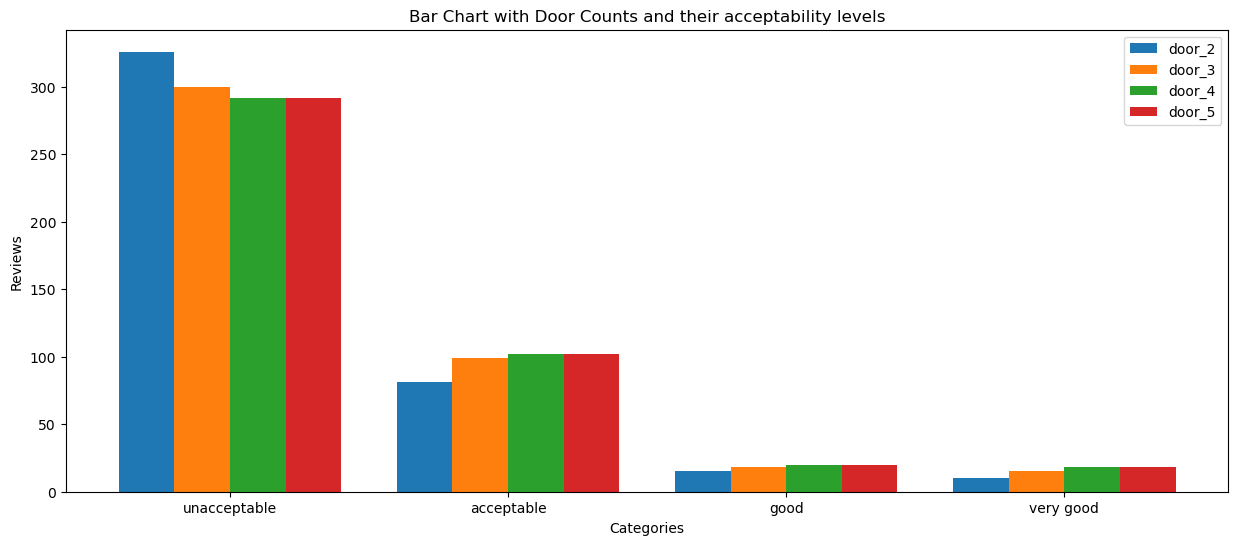

In [15]:

# Create an array of index positions for the bars
index_positions = np.arange(len(df.index))

# Plot each series with bars next to each other
width = 0.2  # Width of each bar
fig, ax = plt.subplots(figsize=(15, 6))

ax.bar(index_positions - 1.5*width, df['door_2'], width=width, label='door_2')
ax.bar(index_positions - 0.5*width, df['door_3'], width=width, label='door_3')
ax.bar(index_positions + 0.5*width, df['door_4'], width=width, label='door_4')
ax.bar(index_positions + 1.5*width, df['door_5'], width=width, label='door_5')

# Customize the plot
ax.set_title('Bar Chart with Door Counts and their acceptability levels')
ax.set_xlabel('Categories')
ax.set_ylabel('Reviews')
ax.set_xticks(index_positions)
ax.set_xticklabels(df.index)
ax.legend()

# Show the plot
plt.show()


It appears that the unacceptability of the cars is quite predominant amongst the categories (people are very picky...). However, there is another observation, and this is more or less predictable - the unacceptability of the 2-door cars is the largest amongst the other car types. In real life, 2-door cars are indeed a less preferred and less practical vehicle.

In [16]:
# Let's transpose it, to see the gap between unacceptable and acceptable cars per door type
transposed_df = df.T
transposed_df

,unacceptable,acceptable,good,very good
door_2,326,81,15,10
door_3,300,99,18,15
door_4,292,102,20,18
door_5,292,102,20,18


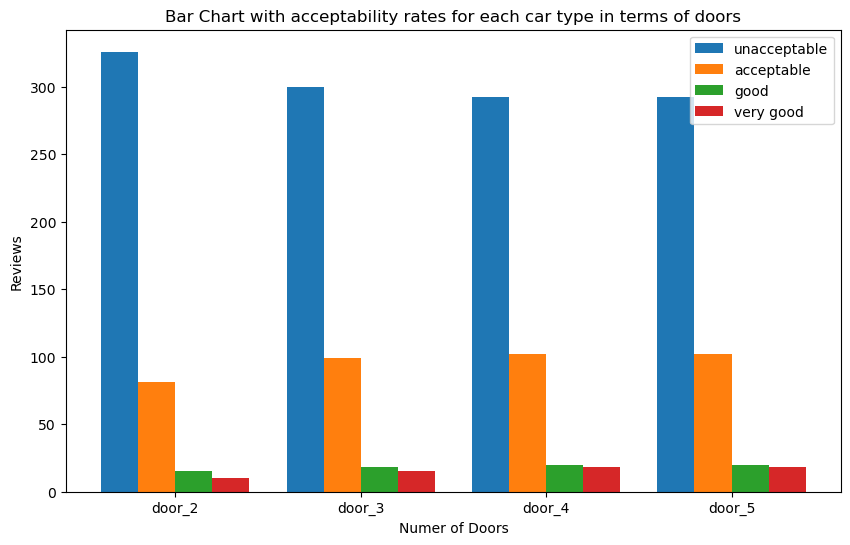

In [17]:
# Create an array of index positions for the bars
index_positions = np.arange(len(df.index))

# Plot each series with bars next to each other
width = 0.2  # Width of each bar
fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(index_positions - 1.5*width, transposed_df['unacceptable'], width=width, label='unacceptable')
ax.bar(index_positions - 0.5*width, transposed_df['acceptable'], width=width, label='acceptable')
ax.bar(index_positions + 0.5*width, transposed_df['good'], width=width, label='good')
ax.bar(index_positions + 1.5*width, transposed_df['very good'], width=width, label='very good')

# Customize the plot
ax.set_title('Bar Chart with acceptability rates for each car type in terms of doors')
ax.set_xlabel('Numer of Doors')
ax.set_ylabel('Reviews')
ax.set_xticks(index_positions)
ax.set_xticklabels(transposed_df.index)
ax.legend()

# Show the plot
plt.show()


The trend from above about the unacceptability levels is repeated here, but now it is easier to grasp the gap between the unacceptable and the acceptable cars, with unacceptable being almost 4 times more than the next category. In addition, the good and very good vehicles are a very small part of the dataset, but we can see that the 4 and 5-door cars have more occurrences in those categories. Such an event should be expected, as those cars are the most preferred type of vehicle and reliability should be on point there.


Once we have done a simple comparison between the door types and their acceptance levels, let's use some more advanced methods to try and predict the acceptability of a car based on all the features provided. 

For this purpose, we will use the Random Forest Classifier algorithm, which will attempt to tell what acceptance level would each test car have, given the training data provided from the training set. 

In [18]:
# We can either use the original dataframe or split it into X and y, which will be then split further into training
# and testing sets

cardataframe_x = cardataframe[['sales', 'maintenance', 'doors', 'persons', 'lug_boot', 'safety']]

cardataframe_y = cardataframe['acceptability_level']



In [19]:
# split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(cardataframe_x, cardataframe_y, test_size=0.4, random_state=42)

# Create random forrest classifier object
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# train the classifier
rf.fit(X_train, y_train)

# predict on test set
y_pred = rf.predict(X_test)

In [20]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)

Accuracy:  0.9739884393063584


As it can be seen, the accuracy of the model is very high (1 being exact match to the original), thanks to the big number of records, and, supposedly, to the easily recognisable patterns in the features.

Now, let's visualize where the errors were made:

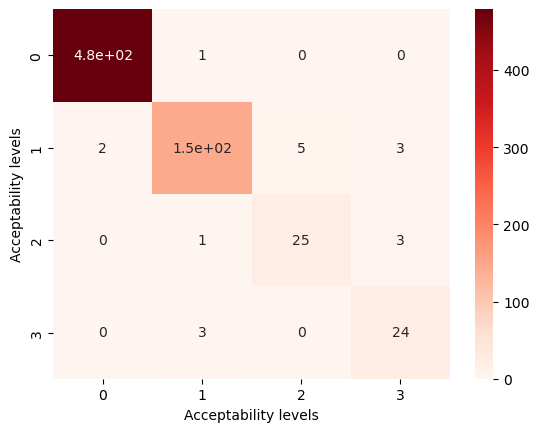

In [37]:
# Let's calculate the confustion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix heatmap, which shows where the errors were appearing.
sns.heatmap(cm, annot=True, cmap="Reds")
plt.xlabel('Acceptability levels')
plt.ylabel("Acceptability levels")
plt.show() 

As we can see, the confusion matrix shows where we have diversions from the original acceptability levels, i.e. around the diagonal from top left to bottom right. Fortunately, those errors are a very small part of all the predictions and the Random Forest Classifier has successfully predicted almost all of the categories.

## Proportional representation of World's Capitals by Population on a World Map
<hr>

The second part of this research will combine two datasets - Population of Capital Cities in the World and the Coordinates (Latitude and Longitude) of each capital. 

The end goal is to present the capitals on a world map with dots having a size proportional to their population when compared with the other capitals. This visualisation could give a better understanding of how the world's population is distributed (at least in the capital cities). 


To cope with the initial formatting, it was necessary to make some amendments to the datasets. 

In the first dataset, the degrees were in Degrees/ Minutes format together with a direction sign (N, S, E, W) as seen in the image below. Those column values have to be changed into decimal degrees, e.g. 45 degrees and 30 minutes South would become -45.5

<img src="initial_coordinates_format.png" alt="initial_formatting" style="width:800px;height:400px;">

**Source: [Capitals and their coordinates](http://www.csgnetwork.com/llinfotable.html)**


In [22]:
content = pd.read_csv("csv_geo_coordinates_of_capitals.csv")
    
content.head()

,Country,Capital,Latitude,Longitude
0,Afghanistan,Kabul,34.28N,69.11E
1,Albania,Tirane,41.18N,19.49E
2,Algeria,Algiers,36.42N,03.08E
3,American Samoa,Pago Pago,14.16S,170.43W
4,Andorra,Andorra la Vella,42.31N,01.32E


Creating a function to convert Decimal Minutes (DM) coordinates to decimal for the Latitude column to output the wanted format. The four decimal points of the coordinates were intentionally selected to give a better accuracy to the locations.

In [23]:

def dms_to_decimal(coord):
    direction = coord[-1]  # Get the last character (N or S)
    degrees, minutes = map(float, coord[:-1].split('.'))
    decimal = degrees + minutes / 60
    if direction == 'S':
        decimal *= -1
    return "{:.4f}".format(decimal)

# make the column string dtype
content["Latitude"] = content["Latitude"].astype(str)


# Apply the function to the 'Latitude' column
content['Latitude'] = content['Latitude'].apply(dms_to_decimal)

# Display the modified DataFrame
print(content)

            Country           Capital  Latitude Longitude
0       Afghanistan             Kabul   34.4667    69.11E
1           Albania            Tirane   41.3000    19.49E
2           Algeria           Algiers   36.7000    03.08E
3    American Samoa         Pago Pago  -14.2667   170.43W
4           Andorra  Andorra la Vella   42.5167    01.32E
..              ...               ...       ...       ...
194       Venezuela           Caracas   10.5000    66.55W
195        Viet Nam             Hanoi   21.0833   105.55E
196      Yugoslavia          Belgrade   44.8333    20.37E
197          Zambia            Lusaka  -15.4667    28.16E
198        Zimbabwe            Harare  -17.7167    31.02E

[199 rows x 4 columns]


Let's do the same with the Longitude column 

In [24]:
def dms_to_decimal(coord):
    direction = coord[-1]  # Get the last character (N or S)
    degrees, minutes = map(float, coord[:-1].split('.'))
    decimal = degrees + minutes / 60
    if direction == 'W':
        decimal *= -1
    return "{:.4f}".format(decimal)

# make the column string dtype
content["Longitude"] = content["Longitude"].astype(str)

# Apply the function 
content['Longitude'] = content['Longitude'].apply(dms_to_decimal)

# Display the modified DataFrame
print(content)

            Country           Capital  Latitude  Longitude
0       Afghanistan             Kabul   34.4667    69.1833
1           Albania            Tirane   41.3000    19.8167
2           Algeria           Algiers   36.7000     3.1333
3    American Samoa         Pago Pago  -14.2667  -170.7167
4           Andorra  Andorra la Vella   42.5167     1.5333
..              ...               ...       ...        ...
194       Venezuela           Caracas   10.5000   -66.9167
195        Viet Nam             Hanoi   21.0833   105.9167
196      Yugoslavia          Belgrade   44.8333    20.6167
197          Zambia            Lusaka  -15.4667    28.2667
198        Zimbabwe            Harare  -17.7167    31.0333

[199 rows x 4 columns]


Once we have the data in this format, it should be matched with the data of a population dataset, which lists countries, their capitals with their respective population before we reach the end goal. 

As mentioned, the end idea is to show a world map showing the world capitals with dots as large as their population is proportional to all the other capitals. 

Before that, we need to obtain the data from the second dataset. The idea here is to show data processing techniques, not the most up-to-date information about the capitals' population, as the data is from 2007. This could be an encouragement for other researchers to reuse this work for this purpose and make comparisons. 

**Source: [Population of Capital Cities 2007](https://data.amerigeoss.org/dataset/world-population-of-capital-cities-2007/resource/2f2c6f84-5ec4-405e-95ad-eec08e28f86f?view_id=701816ea-0d4c-47f5-b2db-7a983a269aab)**

In [25]:
file_path = "csv_capital_cities_population.csv"

In [26]:
cap_population = pd.read_csv(file_path)

cap_population.head()

,Country,Capital,Population000s
0,Afghanistan,Kabul,"3,324"
1,Albania,Tirana,406
2,Algeria,Algiers,"3,355"
3,American Samoa,Pago Pago,58
4,Andorra,Andorra la Vella,24


As seen, in raw format, the population is given in thousands, not directly in their full count. This is why this has been improved on the side.

Due to some complications in the names of the capitals - é, à, etc. the names had to be made more standardized. The next commands and error messages show the issues with the dataset, which are now, of course, resolved. Again, it can be used by future researchers to find the information that cannot be parsed properly. For this document, it remains commented.

In [27]:
# with open(file_path, 'rb') as file:
#     chunk = file.read(100)
# chunk

As mentioned above, the two tables were matched together to combine the geo location and the population of each capital. The working table is available in the folder under the name [csv_geoloc_ready](csv_geoloc_ready.csv), but will not be presented, as it was used for the data processing. As a result, a third dataset was created -  [geo_pop_full](geo_pop_full.csv)



The dataset obtained from this process is shown below:

In [28]:
population = pd.read_csv("geo_pop_full.csv")

population.head()

,Country,Capital,Latitude,Longitude,Population
0,Afghanistan,Kabul,34.4667,69.1833,3324000
1,Albania,Tirane,41.3000,19.8167,406000
2,Algeria,Algiers,36.7000,3.1333,3355000
3,American Samoa,Pago Pago,-14.2667,-170.7167,58000
4,Andorra,Andorra la Vella,42.5167,1.5333,24000


The next step is to make a different representation of the population, and more accurately - to make it proportionally equal to a dot with a size having values within a different range. After few experiments, the best minimum and maximum values are:
- 1 - least populated city
- 200 - most populated city


First, let's find the min and max values in the Population column.

In [29]:
# Find the minimum input value
input_min = population["Population"].min()


# Find the maximum input value
input_max = population["Population"].max()

print(input_min, input_max)

# It appears the min and max input values are:
# input_min = 2000
# input_max = 35670000

2000 35670000


In [30]:
# Set the output values - the range within which the population size dots will be represented
output_min = 1
output_max = 200



Let's create the function scaling the population within those limits 1-200:

In [31]:
def linear_scale(value, input_min, input_max, output_min, output_max):
    input_range = input_max - input_min
    output_range = output_max - output_min
    scaled_value = ((value - input_min) / input_range) * output_range + output_min
    return scaled_value

# Population values
test_values = population["Population"]

# Perform linear scaling
scaled_values = [linear_scale(value, input_min, input_max, output_min, output_max) for value in test_values]

scaled_values = [float("{:.4f}".format(scaled_value)) for scaled_value in scaled_values]
print(f"Scaled values with 4 digits only: \n{scaled_values}")


Scaled values with 4 digits only: 
[19.5342, 3.254, 19.7072, 1.3124, 1.1227, 23.3448, 1.1339, 72.3584, 7.1372, 1.1674, 3.0978, 13.9048, 11.5447, 2.3279, 1.8648, 76.1746, 1.636, 11.0649, 10.7134, 1.0781, 5.2402, 1.4519, 9.8598, 3.0922, 2.2386, 21.0406, 1.0391, 1.1116, 7.6058, 7.3938, 3.3879, 9.1624, 9.9714, 7.3659, 1.6862, 1.1451, 4.7381, 6.4955, 32.8965, 62.9629, 44.306, 1.2455, 8.4204, 8.1526, 22.1955, 4.8329, 13.1404, 2.2888, 7.4719, 19.4059, 44.7914, 7.0479, 4.2415, 1.067, 13.0065, 10.4568, 67.3482, 8.9839, 1.5244, 4.3364, 3.2038, 18.2956, 1.0, 1.1004, 2.2386, 7.2097, 56.2344, 1.3403, 1.7197, 4.2025, 3.2596, 7.1204, 19.9861, 12.8168, 19.0767, 1.0725, 1.0558, 6.7076, 9.3242, 2.83, 1.7309, 12.1585, 6.2724, 10.3341, 2.0601, 89.7823, 51.9997, 44.9253, 31.6746, 6.9028, 5.0952, 19.6235, 4.2304, 200.0, 6.9251, 4.3029, 17.7879, 1.2232, 12.4876, 5.6587, 5.1509, 5.017, 11.3495, 2.1716, 7.4886, 13.1962, 1.0167, 4.0184, 1.4575, 10.4568, 5.0728, 9.0676, 1.6081, 9.3242, 2.0991, 1.5021, 4.7437, 10

Once done, we add the data to the data frame in another column

In [32]:
population["scaled_population"] = scaled_values

In [33]:
population.head()

,Country,Capital,Latitude,Longitude,Population,scaled_population
0,Afghanistan,Kabul,34.4667,69.1833,3324000,19.5342
1,Albania,Tirane,41.3000,19.8167,406000,3.2540
2,Algeria,Algiers,36.7000,3.1333,3355000,19.7072
3,American Samoa,Pago Pago,-14.2667,-170.7167,58000,1.3124
4,Andorra,Andorra la Vella,42.5167,1.5333,24000,1.1227


Before the final step, we extract the Latitude and Longitude columns as lists that will ultimately be added in the coordinates list. 

In [34]:
lng_list = population["Longitude"].to_list()
lat_list = population["Latitude"].to_list()

To make each dot having the respective size, we use the last column of the dataframe as "markersize" as the parameter is called.

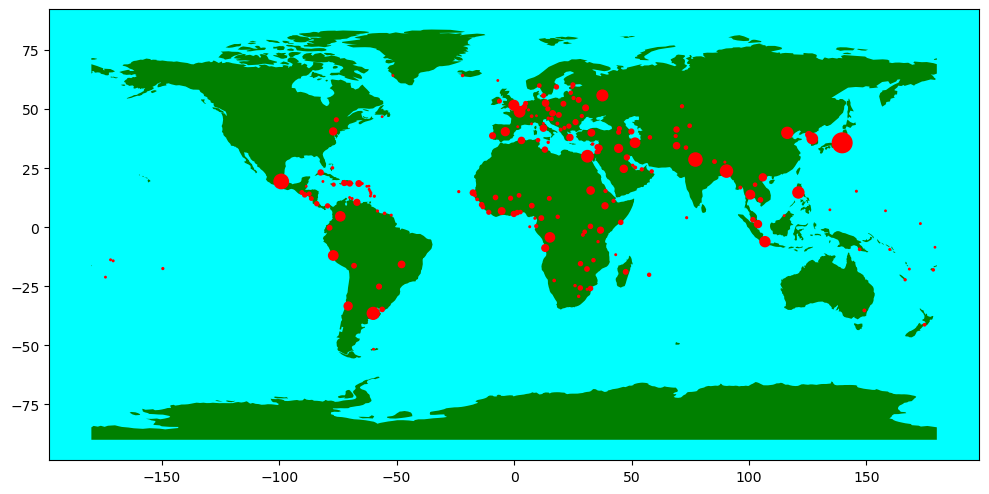

In [35]:
land = gpd.read_file(geodatasets.data.naturalearth.land.url)

fig = plt.figure(figsize = (12, 8))
ax = fig.gca()
land.plot(ax = ax, color = "green")
ax.set_facecolor("aqua")
coordinates =[(x, y) for x, y in zip(lng_list, lat_list)]

points = [Point(x, y) for x, y in coordinates]
points_gdf = gpd.GeoDataFrame(geometry=points, crs=land.crs)

points_gdf.plot(ax=ax, color="red", markersize=population["scaled_population"], marker="o", label="My Points")

plt.show()

# Conclusion

In conclusion, the first dataset attempted to show dependencies between car features and their acceptance levels. Having taken one feature (number of doors), the outcome revealed that the more doors a car has, the more acceptable it is, which can be confirmed in real life due to its practicality. In addition to this, the Random Forest Classifier Algorithm was used to predict the acceptance level of some vehicles given a training set of the same dataset. The algorithm was able to predict correctly almost 98% of the test set and the results were also visually represented. 

The second part of this research had the goal of representing world's capitals as dots on a world map which have a size proportional to their population. The data is taken from 2007, which revealed that Japan is the most populated city in the world, a top place still being held by the Japanese capital with currently having about 37 million citizens. After the data processing and the generating the visualisation, it can be observed that the majority of the capitals are located near the sea/ocean. This could be explained by economic reasons such as better trade with other parts the world, easier access and export of goods from abroad, tourism, history and many more. Such reasons could be further analysed in future pieces of research to better understand why our predecessors have chosen those locations to become the capitals of our countries today. 